VGG16

1.   신경망을 미리 학습한 신경망으로 대체해 학습 (합성곱 신경망의 미세조정)
2.   마지막(완전히 연결된 계층)을 제외한 모든 신경망의 가중치 고정. 마지막 계층은 무작위 가중치를 가지는 것으로 설정해 마지막 계층만 다시 학습

In [1]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [2]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [3]:
# 폴더명 기준으로 라벨 구분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['styro', 'pet', 'can', 'vin', 'plastic', 'paper']


In [4]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기(8대2)
!pip install split-folders

import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 60000 files [00:10, 5788.08 files/s]


In [5]:
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
from torchsummary import summary

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda', index=0)

In [6]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),# 이미지 resize 
        transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자르기
        transforms.RandomHorizontalFlip(),# 데이터 증진(augmentation)
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업에 쓰일 각 채널의 표준값과 표준편차값, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = '/content/data_new' # 이미지 데이터셋에 상단의 transform 내용 적용

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']))

48000 12000


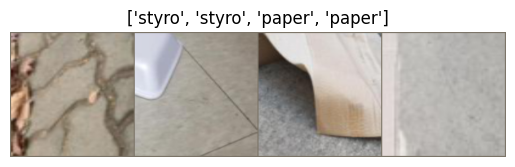

In [9]:
# 데이터 이미지 출력하는 함수 만들기
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # torch.Tensor를 numpy 객체로 변환    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.axis('off')  # 바깥선 지우기
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)    # 이미지 출력
    plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지 생성
    imshow(out, title=[class_names[x] for x in classes]) #  배치사이즈만큼 image, label이 출력

inputs, classes = next(iter(dataloaders['train'])) # 학습 데이터의 배치를 얻기
show_databatch(inputs, classes) # 학습데이터 이미지 출력

In [52]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') 
                imshow(inputs.cpu().data[j])
                print(class_names[preds[j]])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
def train_model(model, optimizer, num_epochs=25): # 모델학습 함수
    since = time.time()

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에폭마다 for문을 넣어주고
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습단계와 테스트 단계를 거쳐서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 아웃풋 설정
                    _, preds = torch.max(outputs, 1) # 인풋에 대현 예측값
                    loss = criterion(outputs, labels) # 예측값과 실제 결과값 비교

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 최적화(optimizer 스텝 증가) 

                # 통계
                running_loss += loss.item() * inputs.size(0) # 교차엔트로피 계산. deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장, 배치 사이즈를 곱해줘 한 배치 사이즈의 loss 총합을 계산
                running_corrects += torch.sum(preds == labels.data) # 예측값이 맞은 횟수 더하기
            if phase == 'train':
                exp_lr_scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 에폭에 따른 loss, accuracy 계산 (전체 데이터 loss합/ 각 데이터셋 크기)
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}') # loss, accuracy 출력

            if phase == 'train':
                loss_history['train'].append(epoch_loss)
                metric_history['train'].append(epoch_acc)
            else:
                loss_history['val'].append(epoch_loss)
                metric_history['val'].append(epoch_acc)

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc: # best_acc, weight 값 저장
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since       # 반복할 때마다 현재 - 기존 시간 계산해 걸린 시간 표시
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_acc:4f}')

    # 제일 잘 나온 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft .classifier[6].in_features # 6계층 배열인 model.classifier를 사용
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names)) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft .parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary
summary(model_ft, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
model_ft, loss_hist, metric_hist = train_model(model_ft, optimizer_ft, num_epochs=10) # 학습을 수행

Epoch 0/9
----------
train Loss: 0.6493 Accuracy: 0.7670
val Loss: 0.3174 Accuracy: 0.8890

Epoch 1/9
----------
train Loss: 0.4702 Accuracy: 0.8323
val Loss: 0.4230 Accuracy: 0.8581

Epoch 2/9
----------
train Loss: 0.4210 Accuracy: 0.8499
val Loss: 0.2827 Accuracy: 0.9038

Epoch 3/9
----------
train Loss: 0.3822 Accuracy: 0.8634
val Loss: 0.2502 Accuracy: 0.9142

Epoch 4/9
----------
train Loss: 0.3537 Accuracy: 0.8733
val Loss: 0.2572 Accuracy: 0.9130

Epoch 5/9
----------
train Loss: 0.3358 Accuracy: 0.8794
val Loss: 0.2249 Accuracy: 0.9253

Epoch 6/9
----------
train Loss: 0.3257 Accuracy: 0.8831
val Loss: 0.2574 Accuracy: 0.9170

Epoch 7/9
----------
train Loss: 0.2178 Accuracy: 0.9212
val Loss: 0.1772 Accuracy: 0.9424

Epoch 8/9
----------
train Loss: 0.1969 Accuracy: 0.9296
val Loss: 0.1699 Accuracy: 0.9442

Epoch 9/9
----------
train Loss: 0.1879 Accuracy: 0.9333
val Loss: 0.1673 Accuracy: 0.9445

Training complete in 234m 2s
Best val Accuracy: 0.944500


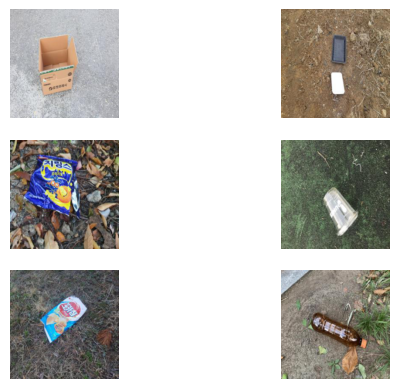

In [ ]:
visualize_model(model_ft) # 예측값 시각화 

In [ ]:
train_acc_history = metric_hist["train"]
torch.stack(train_acc_history).cpu()

tensor([0.7670, 0.8323, 0.8499, 0.8634, 0.8733, 0.8794, 0.8831, 0.9212, 0.9296,
        0.9333], dtype=torch.float64)

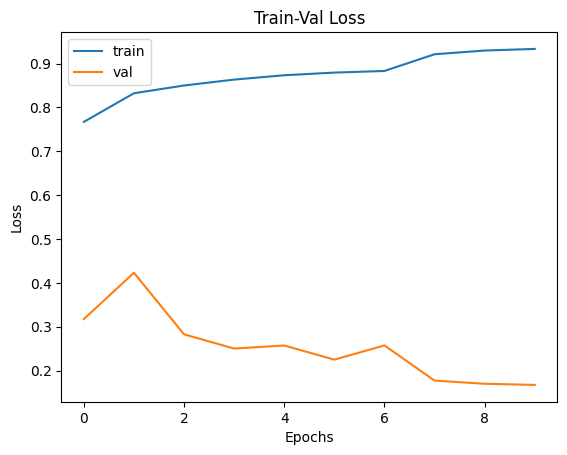

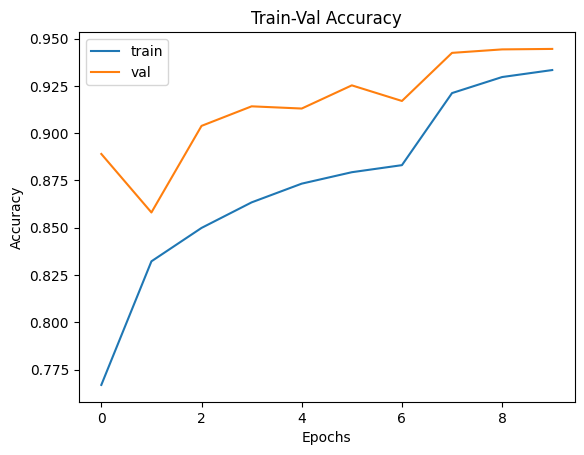

In [ ]:
train_loss_history = loss_hist["train"] # 그래프로 표시
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_acc_history,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [14]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_conv = optim.SGD(model_conv .parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv, loss_hist, metric_hist = train_model(model_conv, optimizer_conv, num_epochs=10) # 학습을 수행

Epoch 0/9
----------
train Loss: 1.2997 Accuracy: 0.6802
val Loss: 0.8226 Accuracy: 0.7953

Epoch 1/9
----------
train Loss: 1.3906 Accuracy: 0.6990
val Loss: 0.7489 Accuracy: 0.8126

Epoch 2/9
----------
train Loss: 1.4048 Accuracy: 0.7041
val Loss: 0.8705 Accuracy: 0.7966

Epoch 3/9
----------
train Loss: 1.4475 Accuracy: 0.6995
val Loss: 0.8233 Accuracy: 0.8157

Epoch 4/9
----------
train Loss: 1.4473 Accuracy: 0.7029
val Loss: 0.9283 Accuracy: 0.7873

Epoch 5/9
----------
train Loss: 1.4273 Accuracy: 0.7061
val Loss: 0.8178 Accuracy: 0.8103

Epoch 6/9
----------
train Loss: 1.4566 Accuracy: 0.7056
val Loss: 0.7340 Accuracy: 0.8232

Epoch 7/9
----------
train Loss: 1.1735 Accuracy: 0.7288
val Loss: 0.5517 Accuracy: 0.8442

Epoch 8/9
----------
train Loss: 1.0099 Accuracy: 0.7396
val Loss: 0.5329 Accuracy: 0.8431

Epoch 9/9
----------
train Loss: 0.9259 Accuracy: 0.7434
val Loss: 0.4901 Accuracy: 0.8474

Training complete in 82m 42s
Best val Accuracy: 0.847417


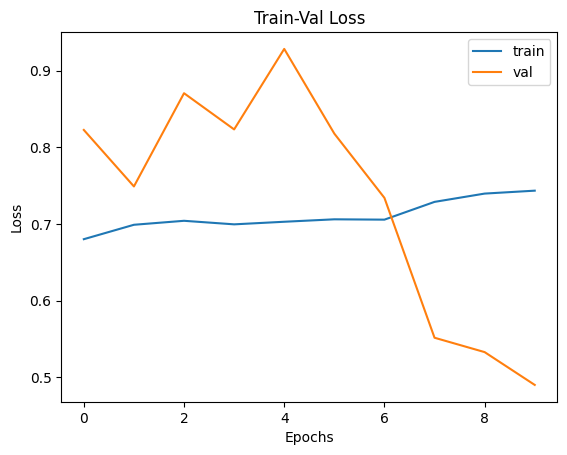

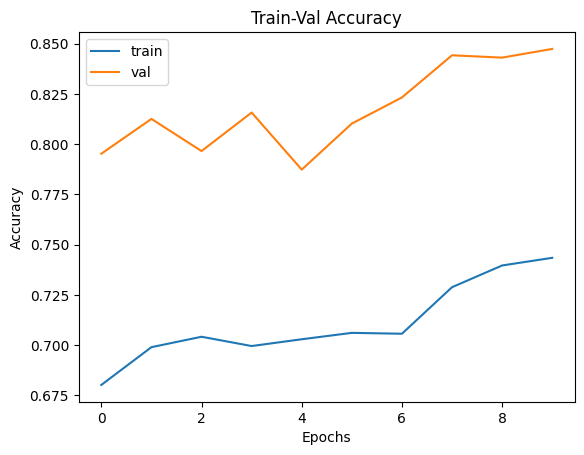

In [16]:
train_loss_history = loss_hist["train"] # 그래프로 표시
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_acc_history,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

paper
vin
vin
can
pet
styro


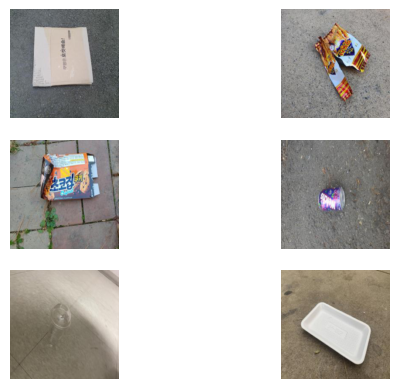

In [53]:
visualize_model(model_conv) # 예측값 시각화 